In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transactions-data-bank-fraud-detection/Fraud.csv


In [2]:
fraud_df = pd.read_csv("/kaggle/input/transactions-data-bank-fraud-detection/Fraud.csv", parse_dates=["Date"])

/tmp/ipykernel_19/2485261295.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fraud_df = pd.read_csv("/kaggle/input/transactions-data-bank-fraud-detection/Fraud.csv", parse_dates=["Date"])


In [3]:
fraud_df.head()

,Date,nameOrig,amount,oldbalanceOrg,newbalanceOrig,City,type,Card Type,Exp Type,Gender,isFraud
0,2013-05-26,C2011200430,242.0,302.0,60.0,"Ahmedabad, India",TRANSFER,Gold,Food,F,1
1,2012-07-26,C931301500,7081.0,46066.0,38985.0,"Delhi, India",TRANSFER,Gold,Entertainment,M,1
2,2012-04-12,C963642457,16355.0,30355.0,14000.0,"Kolkata, India",TRANSFER,Silver,Fuel,F,1
3,2012-01-28,C1439438217,20820.0,39663.0,18843.0,"Lucknow, India",TRANSFER,Gold,Food,F,1
4,2014-04-16,C892940485,6071.0,35586.0,29515.0,"Bengaluru, India",TRANSFER,Gold,Fuel,M,1


In [4]:
fraud_df.describe()

,Date,amount,oldbalanceOrg,newbalanceOrig,isFraud
count,1048574,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06
mean,2013-02-26 19:18:36.892847104,3.802767e+04,8.801983e+05,8.421706e+05,1.676420e-01
min,2011-10-09 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2012-06-18 00:00:00,6.470000e+02,4.343812e+03,9.180000e+02,0.000000e+00
50%,2013-02-26 00:00:00,8.263000e+03,3.653918e+04,2.055200e+04,0.000000e+00
75%,2013-11-05 00:00:00,2.365000e+04,1.366425e+05,9.030729e+04,0.000000e+00
max,2015-05-26 00:00:00,1.000000e+07,3.890000e+07,3.889319e+07,1.000000e+00
std,NaN,1.105168e+05,2.969968e+06,2.936373e+06,3.735482e-01


### Split Train/Test Data

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

In [6]:
# create train_test

X_train_val, X_test = train_test_split(fraud_df, test_size=0.1, random_state=42)

## Data Inspection

In [7]:
## missing values

X_train_val.isna().any()

Date              False
nameOrig          False
amount            False
oldbalanceOrg     False
newbalanceOrig    False
City              False
type              False
Card Type         False
Exp Type          False
Gender            False
isFraud           False
dtype: bool

In [8]:
## duplicated rows

X_train_val.duplicated().any()

False

In [9]:
## Information on columns

X_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943716 entries, 979635 to 121958
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            943716 non-null  datetime64[ns]
 1   nameOrig        943716 non-null  object        
 2   amount          943716 non-null  float64       
 3   oldbalanceOrg   943716 non-null  float64       
 4   newbalanceOrig  943716 non-null  float64       
 5   City            943716 non-null  object        
 6   type            943716 non-null  object        
 7   Card Type       943716 non-null  object        
 8   Exp Type        943716 non-null  object        
 9   Gender          943716 non-null  object        
 10  isFraud         943716 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 86.4+ MB


In [10]:
#Get numerical and categorical columns for analysis

cat_cols = X_train_val.select_dtypes("object").columns.tolist()[1:]
num_cols = X_train_val.select_dtypes(include=np.number).columns.tolist()

In [11]:
# print categories in categorical columns

def view_cat_cols(df, cols):
    for col in cols:
        print("*************************")
        print(df[col].value_counts(normalize=True))
        print("*************************")

In [12]:
view_cat_cols(X_train_val, cat_cols)

*************************
City
Bengaluru, India          0.137102
Ahmedabad, India          0.134784
Greater Mumbai, India     0.134722
Delhi, India              0.134339
Hyderabad, India          0.029883
                            ...   
Fazilka, India            0.000036
Bagaha, India             0.000036
Hugli-Chinsurah, India    0.000036
Godhra, India             0.000035
Varanasi, India           0.000033
Name: proportion, Length: 986, dtype: float64
*************************
*************************
type
CASH_OUT    0.356303
PAYMENT     0.337705
CASH_IN     0.216306
TRANSFER    0.082779
DEBIT       0.006907
Name: proportion, dtype: float64
*************************
*************************
Card Type
Silver       0.262785
Signature    0.247563
Platinum     0.245313
Gold         0.244187
Classic      0.000076
Mass         0.000076
Name: proportion, dtype: float64
*************************
*************************
Exp Type
Food              0.209876
Fuel              0.201923
B

In [13]:
## Create new column
X_train_val["location"] = X_train_val["City"].apply(lambda X: X.split(" ")[0].split(",")[0])

In [14]:
cat_cols.append("location")
view_cat_cols(X_train_val, cat_cols)

*************************
City
Bengaluru, India          0.137102
Ahmedabad, India          0.134784
Greater Mumbai, India     0.134722
Delhi, India              0.134339
Hyderabad, India          0.029883
                            ...   
Fazilka, India            0.000036
Bagaha, India             0.000036
Hugli-Chinsurah, India    0.000036
Godhra, India             0.000035
Varanasi, India           0.000033
Name: proportion, Length: 986, dtype: float64
*************************
*************************
type
CASH_OUT    0.356303
PAYMENT     0.337705
CASH_IN     0.216306
TRANSFER    0.082779
DEBIT       0.006907
Name: proportion, dtype: float64
*************************
*************************
Card Type
Silver       0.262785
Signature    0.247563
Platinum     0.245313
Gold         0.244187
Classic      0.000076
Mass         0.000076
Name: proportion, dtype: float64
*************************
*************************
Exp Type
Food              0.209876
Fuel              0.201923
B

- No empty or duplicated rows
- Data has been processed and in right format

## EDA

In [15]:
# import chart libraries

import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

params = {
    'figure.figsize': [10, 6],
    'axes.titlesize': 10,
    'axes.labelsize': 8
}

matplotlib.rcParams.update(params)

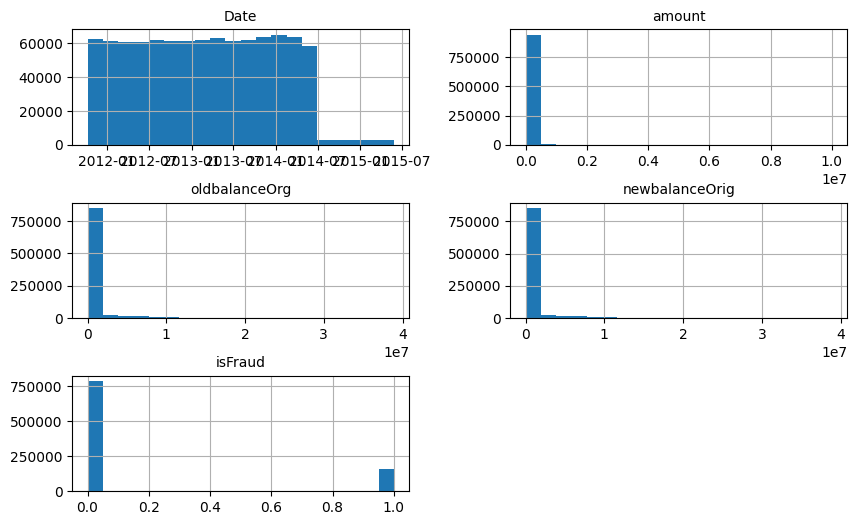

In [16]:
X_train_val.hist(bins=20)
plt.subplots_adjust(hspace=0.5)
plt.xticks(rotation=45)
plt.show()

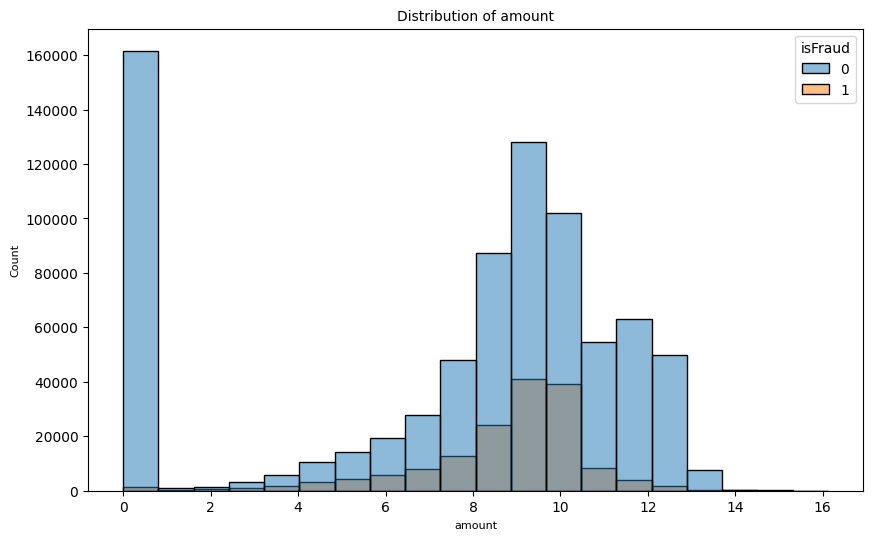

In [17]:
# distribution of the amount

sns.histplot(X_train_val, x=np.log1p(X_train_val["amount"]), bins=20, hue="isFraud")
plt.title("Distribution of amount")
plt.show()

- We transform the highly skewed data using nlog1 to get a more general view on the variable
- We use np.log1p as it handles zero values gracefully

In [18]:
percentage_diff = abs((X_train_val["newbalanceOrig"] - X_train_val["oldbalanceOrg"]) / X_train_val["oldbalanceOrg"]) * 100

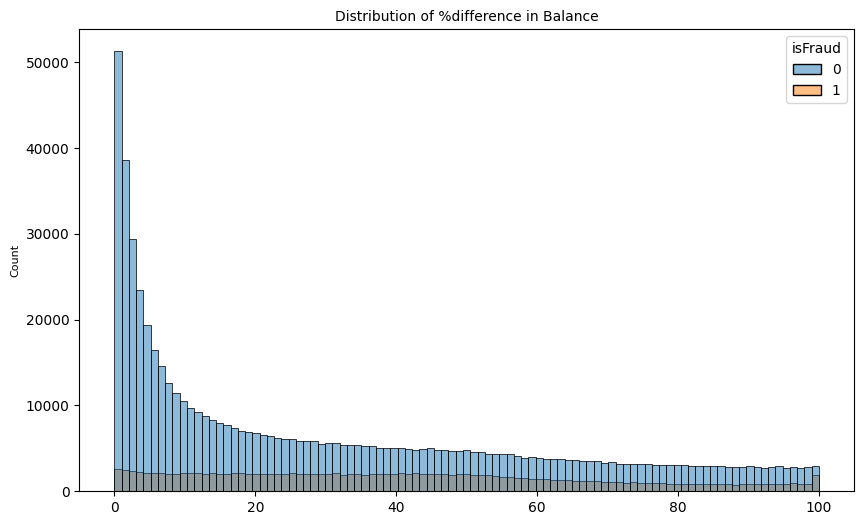

In [19]:
sns.histplot(X_train_val, x=percentage_diff, hue="isFraud", common_norm=True)
plt.title("Distribution of %difference in Balance")
plt.show()

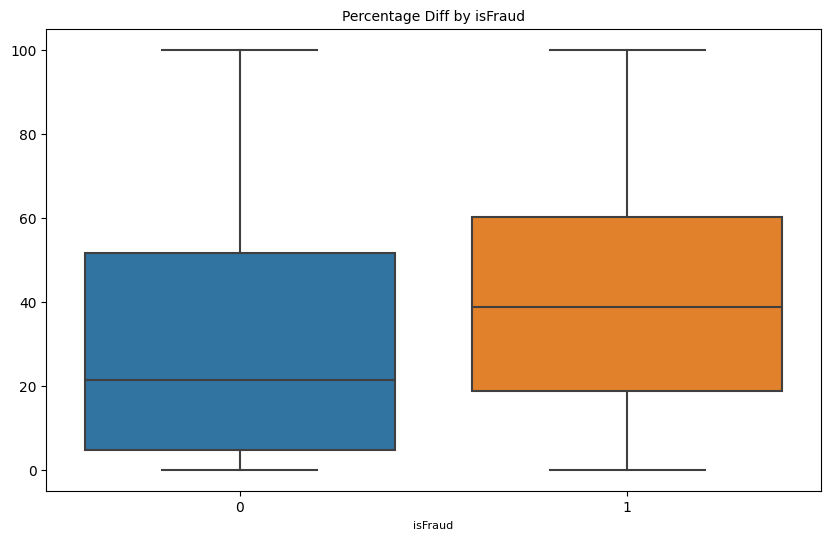

In [20]:
#boxplot of %diff in balance

sns.boxplot(X_train_val, x="isFraud", y=percentage_diff)
plt.title("Percentage Diff by isFraud")
plt.show()

- Balance Difference that are higher tend to be classified as fraudulent
- 40% change seems to the average threshold for Fraudulent transactions

<Axes: xlabel='type'>

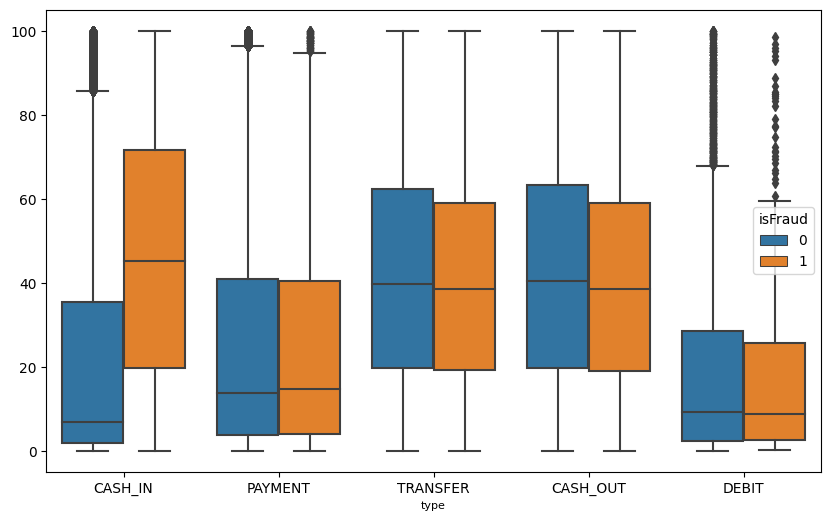

In [21]:
sns.boxplot(X_train_val, x="type", y=percentage_diff, hue="isFraud")

- Transaction with type "CASH-IN" and high difference ratio is likely to be fraudulent as show depicted above
- We can Create a column that classifies CASH-IN with high %diffence and others 

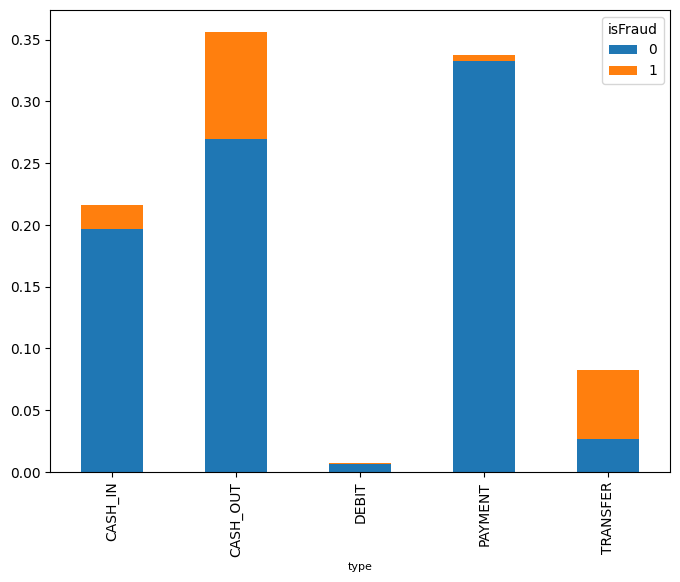

In [22]:
# Investigate Contigency Tables of Columns

freq = pd.crosstab(X_train_val["type"], X_train_val["isFraud"])
proportions = freq/len(X_train_val)

proportions.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.show()

- Seems "Transfer" Transactions are more likely to be Fraudulent
- We can investigate further

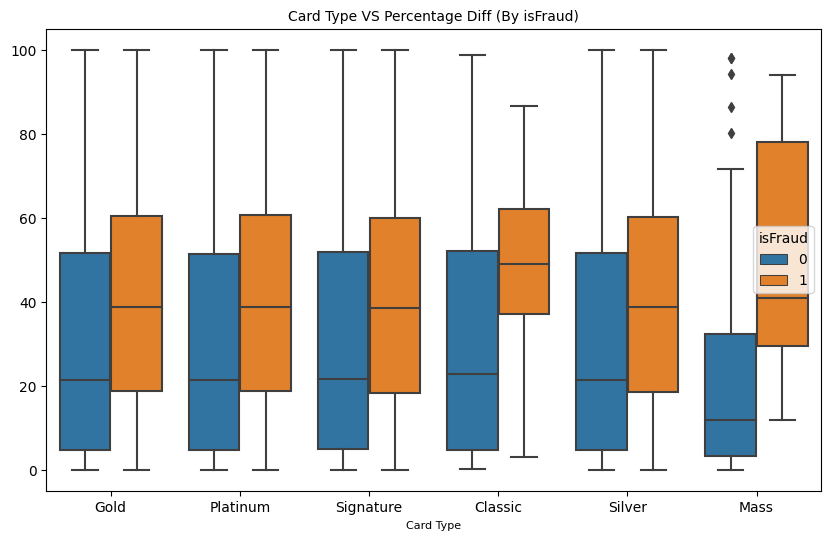

In [23]:
sns.boxplot(X_train_val, x="Card Type", y=percentage_diff, hue="isFraud")
plt.title("Card Type VS Percentage Diff (By isFraud)")
plt.show()

- We can see that when the Card type is "Mass" and the percentage difference in balance is high, it's most likely to be a fraudulent transaction
- Create a categorical column for this as well

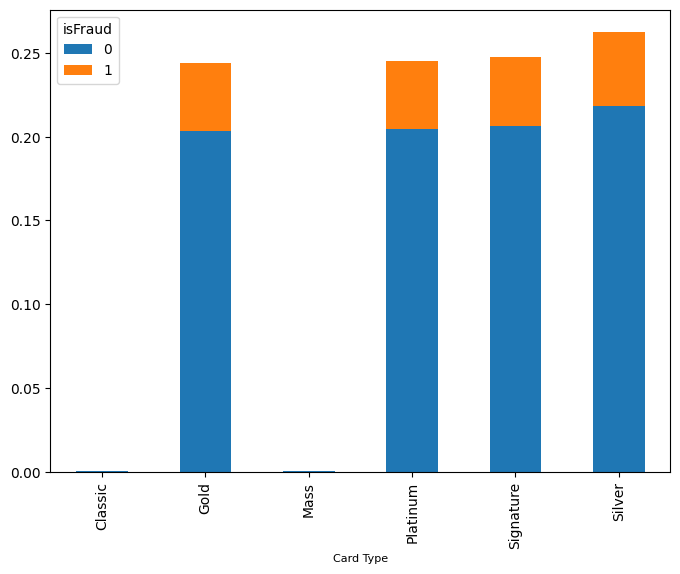

In [24]:
# Investigate Contigency Tables of Columns

freq = pd.crosstab(X_train_val["Card Type"], X_train_val["isFraud"])
proportions = freq/len(X_train_val)

proportions.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.show()

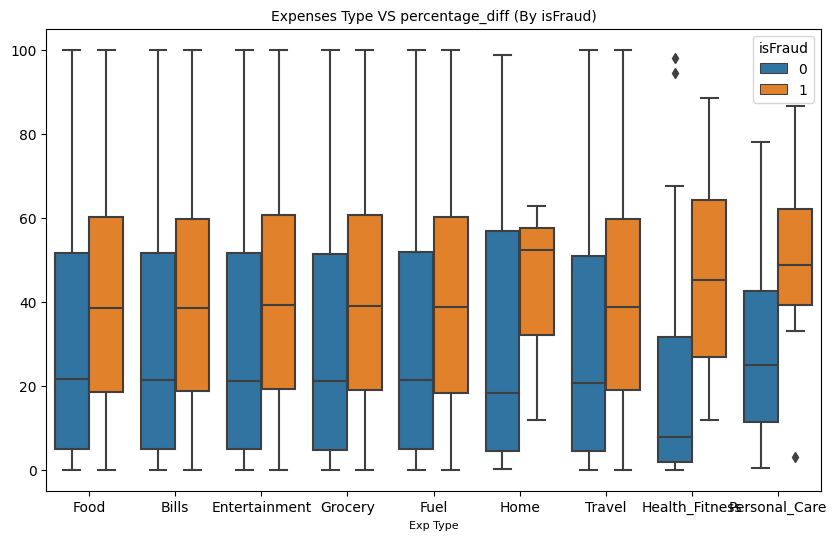

In [25]:
# visulization for gender analysis
sns.boxplot(X_train_val, x="Exp Type", y=percentage_diff, hue="isFraud")
plt.title("Expenses Type VS percentage_diff (By isFraud)")
plt.show()

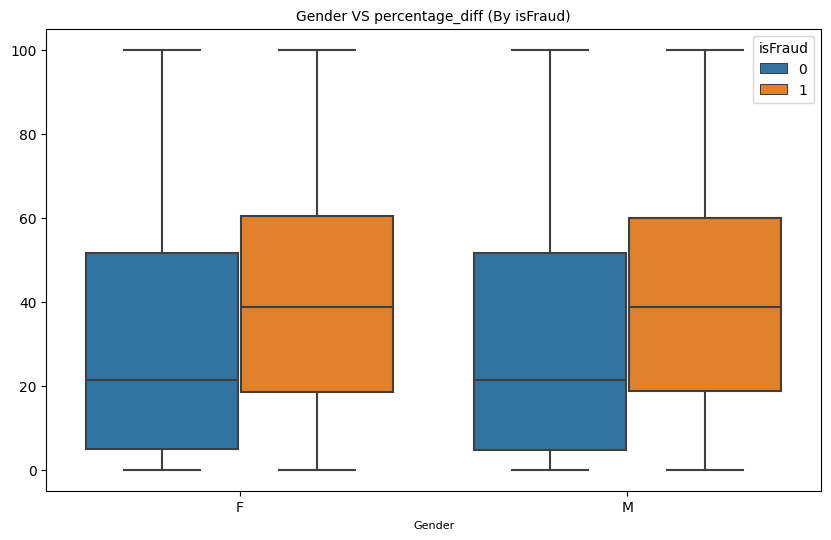

In [26]:
# visulization for gender analysis
sns.boxplot(X_train_val, x="Gender", y=percentage_diff, hue="isFraud")
plt.title("Gender VS percentage_diff (By isFraud)")
plt.show()

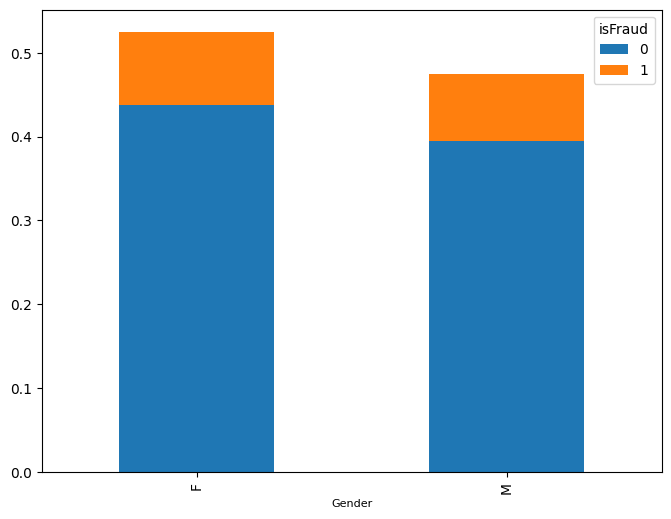

In [27]:
freq = pd.crosstab(X_train_val["Gender"], X_train_val["isFraud"])
proportions = freq/len(X_train_val)

proportions.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.show()

- There are no correlations between Gender and isFraud

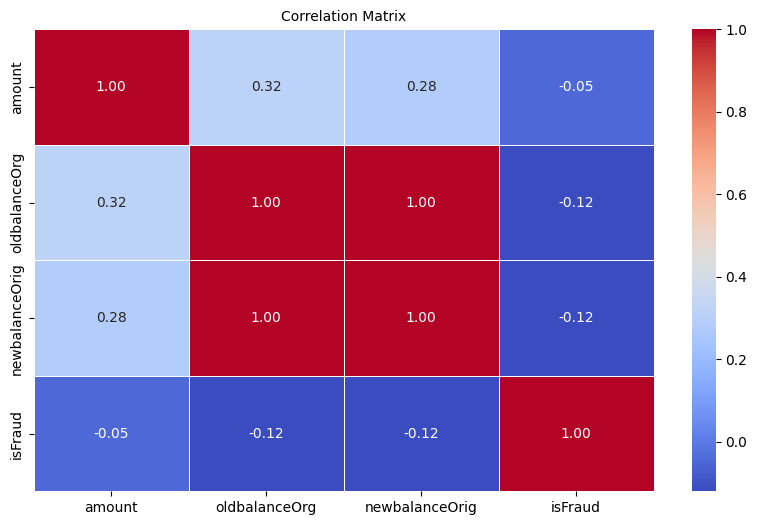

In [28]:
## Check the correlation Matrix

correlation = X_train_val[num_cols].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Key Findings:
- Transcations with amount equal zero (0) are unlikely to be fraudulent
- Using a newly created variable, we calculated the percentage diff between the new balance and the old balance and this led to some breakthrough in our analysis
- Discovered that a high percentage difference in the balance is likely to be a fraudulent transaction
- Usually approximately 40% difference can be used as a threshold
- Transactiuons with type "CASH-IN" and high difference ratio is likely to be fraudulent
- Transfer transactions are likely to be fraudulent while payment and debit transactions have no fraudulent tendencies
- When a card type is mass and has a high % difference, it is likely to be a fraudulent transaction

### Next Steps:
- **Feature Engineering:** Create Extra features based on the analysis done. E.G, create a categorical column that seperates the "Mass" card type with high difference ratio from the rest. e.t.c

### Split Train/Val Data

In [29]:
X_train, X_val = train_test_split(X_train_val, test_size=0.2, random_state=42)

In [30]:
X_train_features = X_train.drop(columns=["isFraud"])
y_train = X_train["isFraud"]
X_val_features = X_val.drop(columns=["isFraud"])
y_val = X_val["isFraud"]

### Data Preprocessing

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## import libraries for custom transformers
from sklearn.base import BaseEstimator, TransformerMixin

In [32]:
## Feature Engineering Custom Transformer to transform feature (amount) to log
class CustomChangeLog(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["amount"] = np.log1p(X["amount"])
        return X

In [33]:
## Add custom columns transformer

class CustomColumnsAdd(BaseEstimator, TransformerMixin):
    def __init__(self, create_mass_cat=False, create_type_class=False, create_health_class=False):
        self.create_mass_cat = create_mass_cat
        self.create_type_class = create_type_class
        self.create_health_class = create_health_class
        
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["perc_diff"] = abs((X_train_val["newbalanceOrig"] - X_train_val["oldbalanceOrg"]) / X_train_val["oldbalanceOrg"]) * 100
        X["perc_diff"].fillna(0, inplace=True)
        if self.create_mass_cat:
            X["m_class"] = X.apply(lambda X: "A" if X["Card Type"] == "Mass" and X["perc_diff"] > 35 else "B", axis=1)
        if self.create_type_class:
            X["type_class"] = X.apply(lambda X: "A" if X["type"] == "CASH_IN" and X["perc_diff"] > 40 else "B", axis=1)
        if self.create_health_class:
            X["health_class"] = X.apply(lambda X: "A" if X["Exp Type"] == "Health_Fitness" and X["perc_diff"] > 25 else "B", axis=1)
        
        return X

In [34]:
# create Preprocessing Pipelines

numeric_transformer = Pipeline([
    #("impute", IterativeImputer(max_iter=10, random_state=0)),
    ("num", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(sparse=False))
])

In [35]:
num_cols = ["amount","perc_diff"]
cat_cols = ["type", "Exp Type", "m_class", "type_class", "health_class"]

features = num_cols + cat_cols

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
       ("num_transformer", numeric_transformer, num_cols),
        ("cat_transformer", categorical_transformer, cat_cols),
    ]
)

# create pipeline
pipeline = Pipeline(steps=[
    ("log", CustomChangeLog()),
    ("add_cols", CustomColumnsAdd(create_mass_cat=True, create_type_class=True, create_health_class=True)),
    ("preprocessor", preprocessor)
])

In [37]:
transformed_data = pipeline.fit_transform(X_train_features)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
transformed_data

array([[-1.93693485, -0.93497487,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.00233302, -0.82091728,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-1.93693485, -0.93497487,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-1.93693485, -0.93497487,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.03701581,  1.84556651,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.0819385 , -0.93366281,  1.        , ...,  1.        ,
         0.        ,  1.        ]])

## Model

In [39]:
from sklearn.linear_model import SGDClassifier

In [40]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(transformed_data, y_train)

SGDClassifier(random_state=42)

### Model Evaluation

In [41]:
from sklearn.model_selection import cross_val_predict

y_train_preds = cross_val_predict(sgd_clf, transformed_data, y_train, cv=5)

In [42]:
y_train_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

In [44]:
confusion_matrix(y_train, y_train_preds)

array([[608600,  20119],
       [ 84063,  42190]])

In [45]:
accuracy_score(y_train, y_train_preds)

0.8620054783488659

In [46]:
precision_score(y_train, y_train_preds)

0.6771092458553339

In [47]:
recall_score(y_train, y_train_preds)

0.3341702771419293